In [ ]:
# ## 1. Load and Preprocess Burglary Data

import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

burglary_monthly


In [15]:
# ## 2. SARIMA Forecasting for All Wards

import warnings

warnings.filterwarnings("ignore")

def analyze_ward(ward_code, ward_df, test_months=26):
    """Analyze a single ward's SARIMA performance"""
    try:
        ward_df = ward_df[['Month', 'Count']].set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df.isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        # Filter wards with sufficient history
        if len(ward_df) < test_months * 2:
            print(f"{ward_code} has insufficient data")
            print(ward_df)
            return None

        # Split data
        train = ward_df.iloc[:-test_months]
        test = ward_df.iloc[-test_months:]

        # Auto-fit SARIMA
        fitted_model = auto_arima(train['Count'],
                           seasonal=True, m=12,
                           suppress_warnings=True,
                           stepwise=True,
                           error_action='ignore')

        model = SARIMAX(train['Count'],
                       order=fitted_model.order,  # Use the correct normal order
                       seasonal_order=(fitted_model.order[0], fitted_model.order[1], fitted_model.order[2], 12),
                       enforce_stationarity=True,
                       enforce_invertibility=False)

        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=test_months).predicted_mean

        # Calculate residuals
        residuals = np.subtract(test['Count'].to_numpy(), preds)

        print(f"{ward_code} Completed")

        return {
            'ward_code': ward_code,
            'train_size': len(train),
            'test_size': len(test),
            'residuals': residuals,
            'predicted': preds,
            'actual': test['Count'].values,
            'model_order': str(model.order),
            'model_seasonal_order': str(model.seasonal_order)
        }
    except Exception as e:
        print(f"Error processing {ward_df['Ward Code'].iloc[0]}: {str(e)}")
        return None

# Process all wards
results = []
i=0
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    if i > 10:
        break
    analysis = analyze_ward(ward_code, group)
    if analysis:
        results.append(analysis)
        i += 1


# with mp.Pool(processes=mp.cpu_count()) as pool:
#     args = [(ward_code, group) for ward_code, group in burglary_monthly.groupby('Ward Code')]
#     results = pool.map(analyze_ward, args)

# Remove None results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")


E05009317 Completed
E05009318 Completed
E05009319 Completed
E05009320 Completed
E05009321 has NaN values
E05009321 Completed
E05009322 Completed
E05009323 Completed
E05009324 has NaN values
E05009324 Completed
E05009325 Completed
E05009326 has NaN values
E05009326 has more than 10 NaN values, aborted
E05009327 Completed
E05009328 has NaN values
E05009328 has more than 10 NaN values, aborted
E05009329 Completed

Successfully processed 11 wards with sufficient data


In [ ]:
# ## 3. Residual Analysis

# Combine all residuals
all_residuals = []
positive_count = 0
total_residuals = 0

for result in results:
    residuals = result['residuals']
    all_residuals.extend(residuals)
    positive_count += np.sum(residuals > 0)
    total_residuals += len(residuals)

# Calculate statistics
avg_residual = np.mean(all_residuals)
positive_percent = (positive_count / total_residuals) * 100
negative_percent = 100 - positive_percent

print("\nResidual Analysis Results:")
print(f"Average residual (Actual - Predicted): {avg_residual:.2f}")
print(f"Positive residuals: {positive_percent:.1f}%")
print(f"Negative residuals: {negative_percent:.1f}%")

# Visualize distribution
plt.figure(figsize=(12, 6))
plt.hist(all_residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(avg_residual, color='r', linestyle='--',
            label=f'Average Residual ({avg_residual:.2f})')
plt.title('Distribution of Test Residuals Across All Wards')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# ## 4. Ward-level Residual Statistics

# Calculate per-ward averages
ward_stats = []
for result in results:
    ward_residuals = result['residuals']
    ward_stats.append({
        'ward_code': result['ward_code'],
        'avg_residual': np.mean(ward_residuals),
        'positive_percent': np.mean(ward_residuals > 0) * 100,
        'total_residuals': len(ward_residuals)
    })

ward_stats_df = pd.DataFrame(ward_stats)

print("\nTop 5 Wards with Largest Over-prediction (Negative Residuals):")
print(ward_stats_df.sort_values('avg_residual').head())

print("\nTop 5 Wards with Largest Under-prediction (Positive Residuals):")
print(ward_stats_df.sort_values('avg_residual', ascending=False).head())

# Visualize residual signs distribution
plt.figure(figsize=(8, 6))
plt.pie([positive_percent, negative_percent],
        labels=[f'Under-predicted ({positive_percent:.1f}%)',
                f'Over-predicted ({negative_percent:.1f}%)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2ca02c', '#d62728'])
plt.title('Overall Prediction Direction Bias')
plt.show()

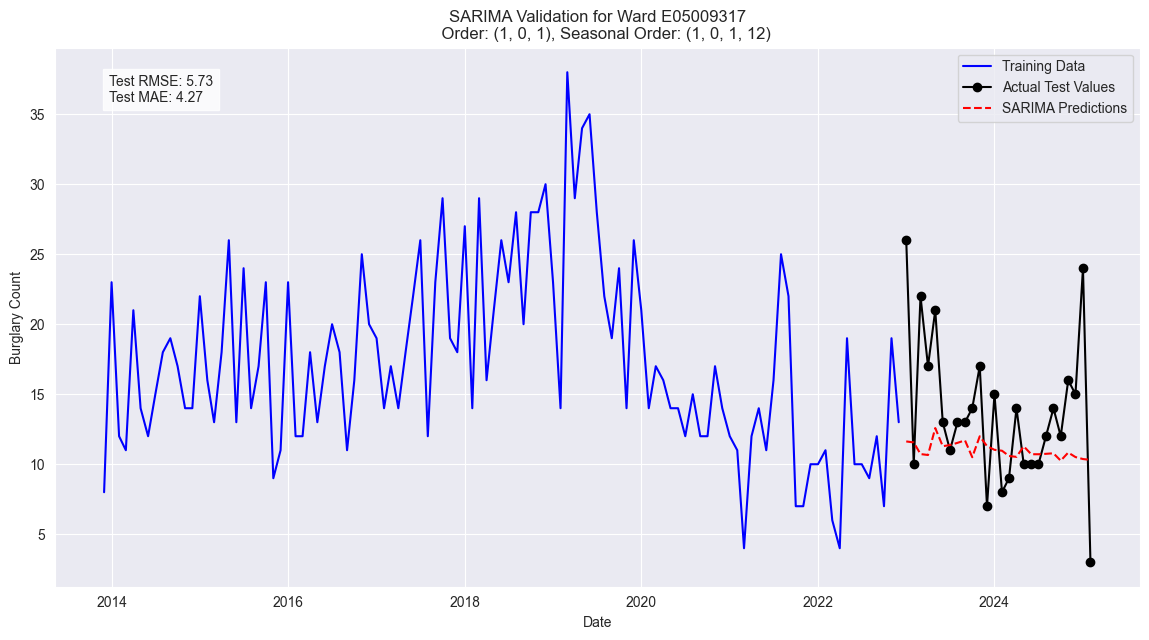


--------------------------------------------------
Residual Statistics for Ward E05009317:
Average Residual: 2.68
Residual Range: [-7.31, 14.37]
Positive Residuals: 65.4%


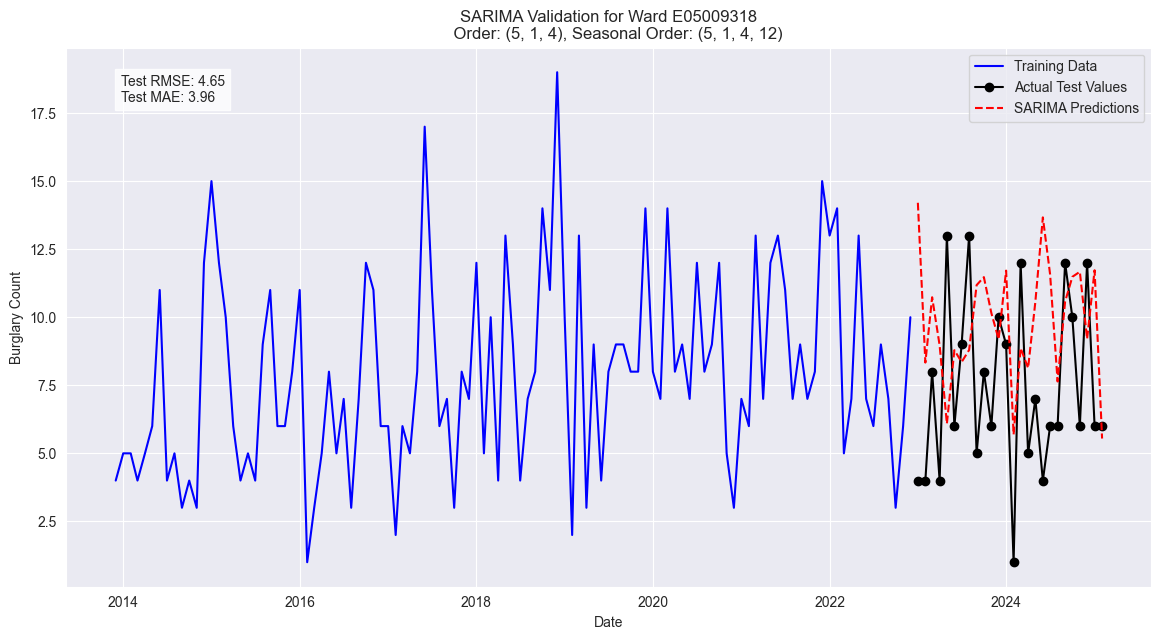


--------------------------------------------------
Residual Statistics for Ward E05009318:
Average Residual: -2.40
Residual Range: [-10.20, 6.91]
Positive Residuals: 30.8%


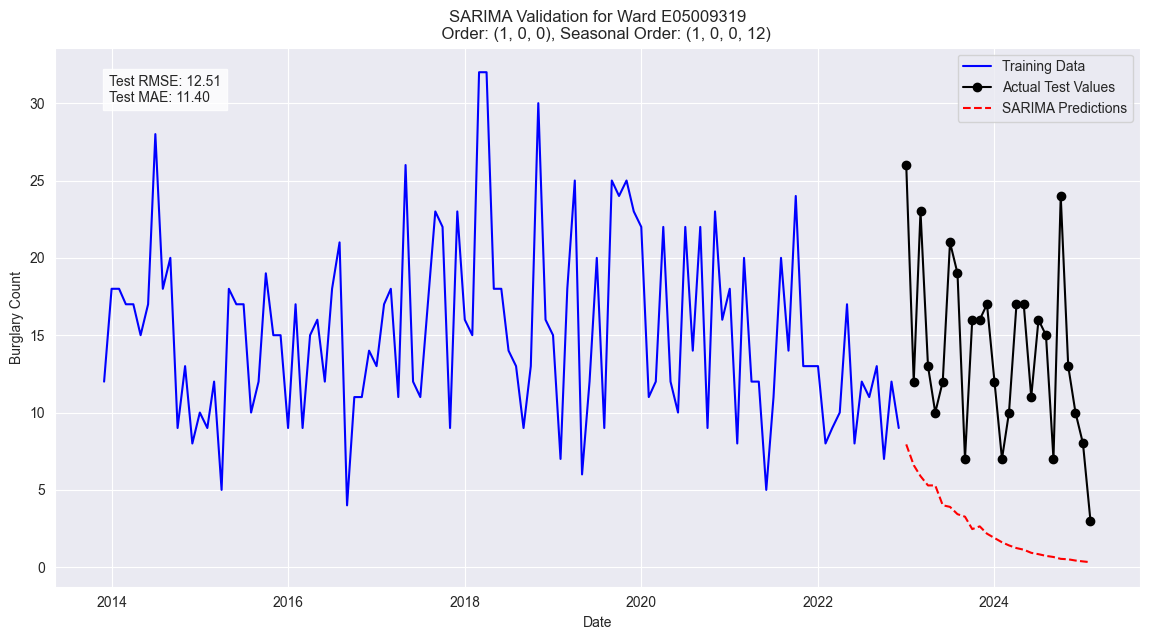


--------------------------------------------------
Residual Statistics for Ward E05009319:
Average Residual: 11.40
Residual Range: [2.68, 23.46]
Positive Residuals: 100.0%


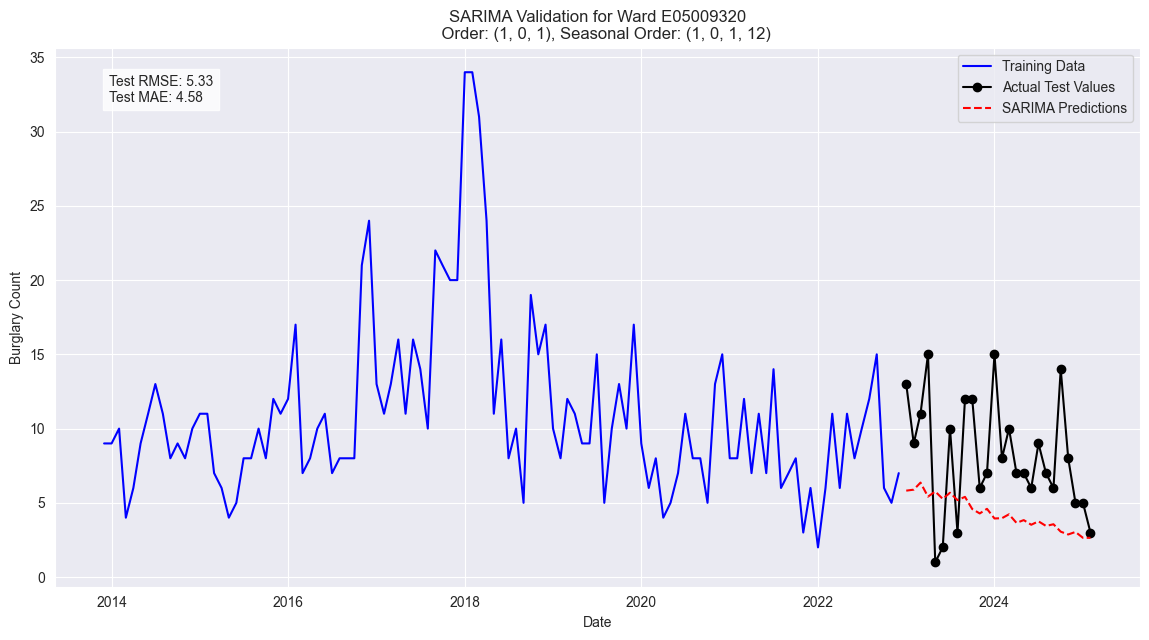


--------------------------------------------------
Residual Statistics for Ward E05009320:
Average Residual: 3.79
Residual Range: [-4.76, 11.05]
Positive Residuals: 88.5%


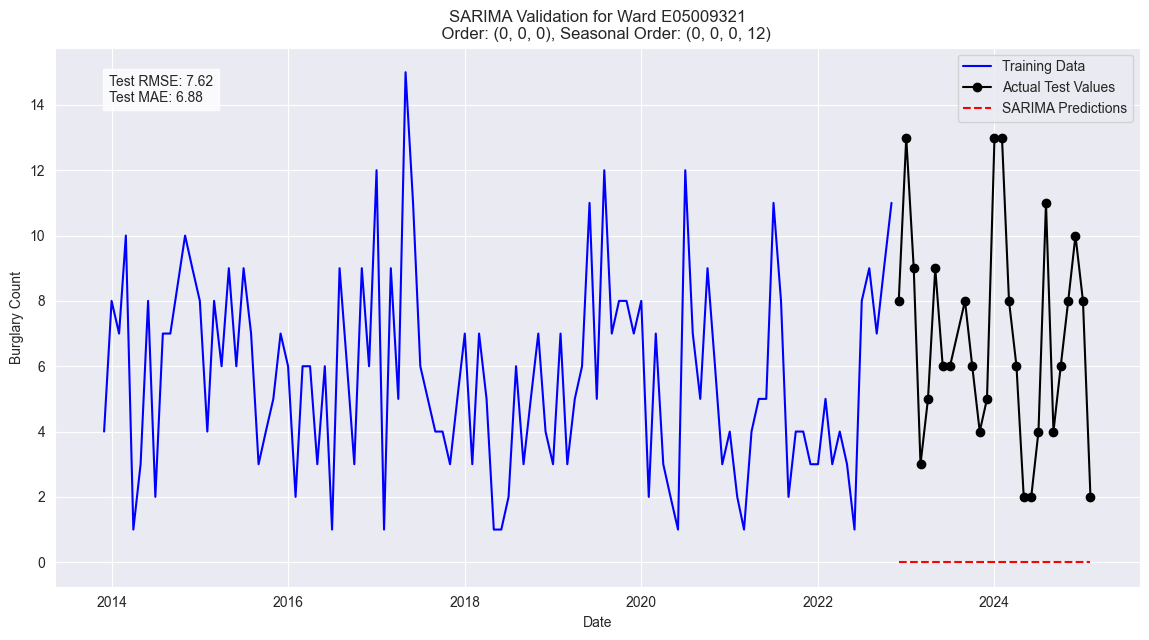


--------------------------------------------------
Residual Statistics for Ward E05009321:
Average Residual: 6.88
Residual Range: [2.00, 13.00]
Positive Residuals: 100.0%


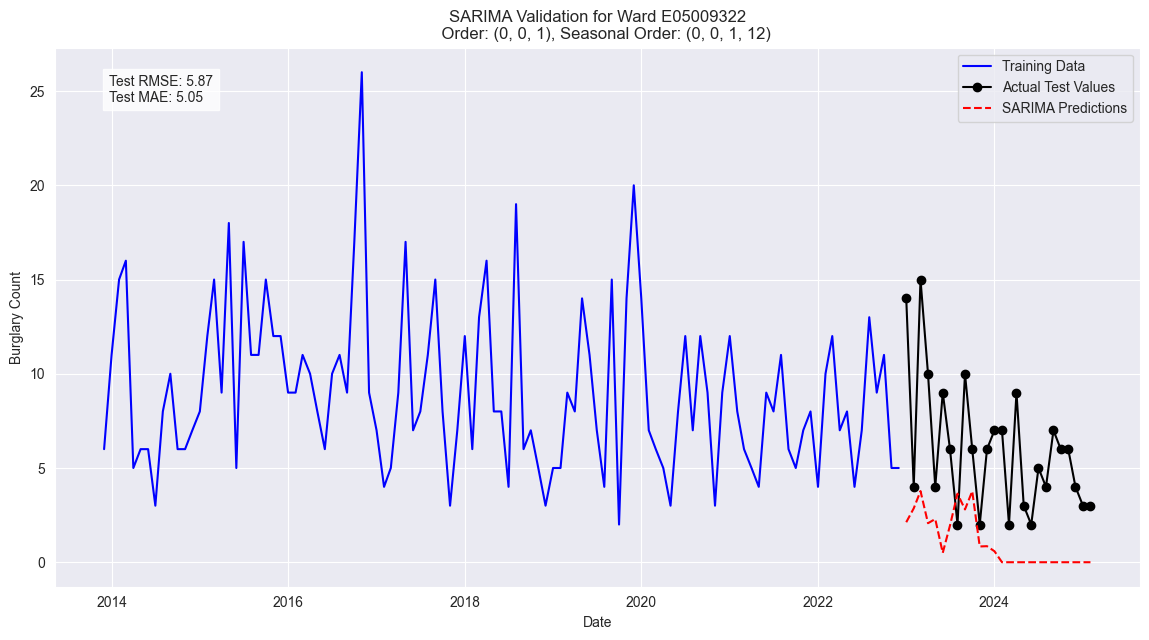


--------------------------------------------------
Residual Statistics for Ward E05009322:
Average Residual: 4.92
Residual Range: [-1.64, 11.88]
Positive Residuals: 96.2%


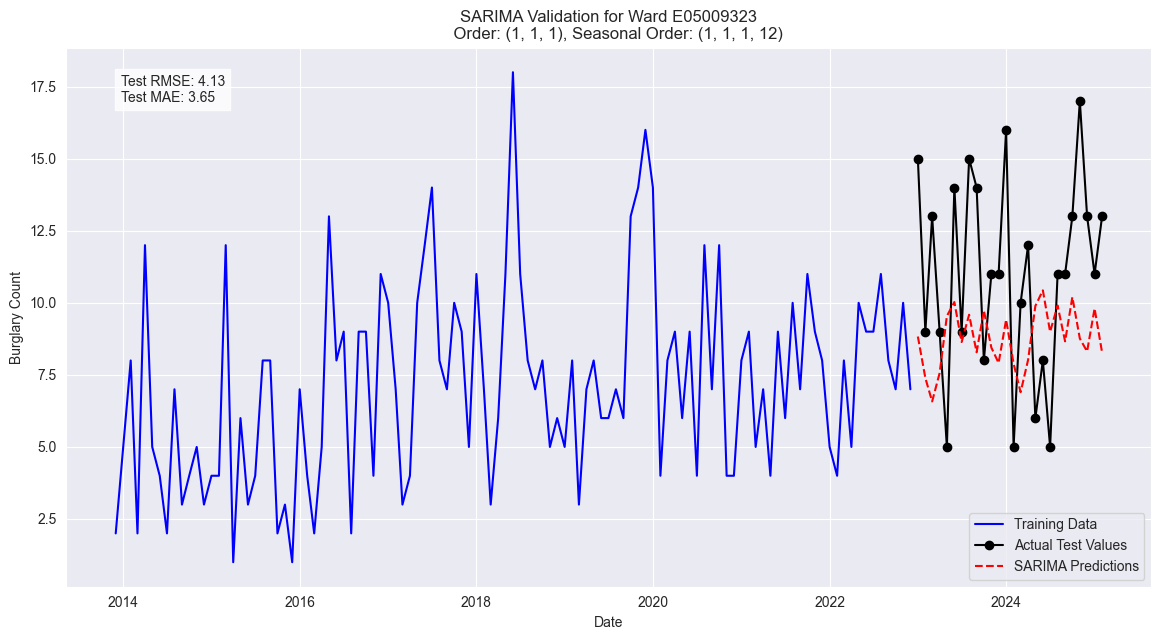


--------------------------------------------------
Residual Statistics for Ward E05009323:
Average Residual: 2.15
Residual Range: [-4.54, 8.24]
Positive Residuals: 76.9%


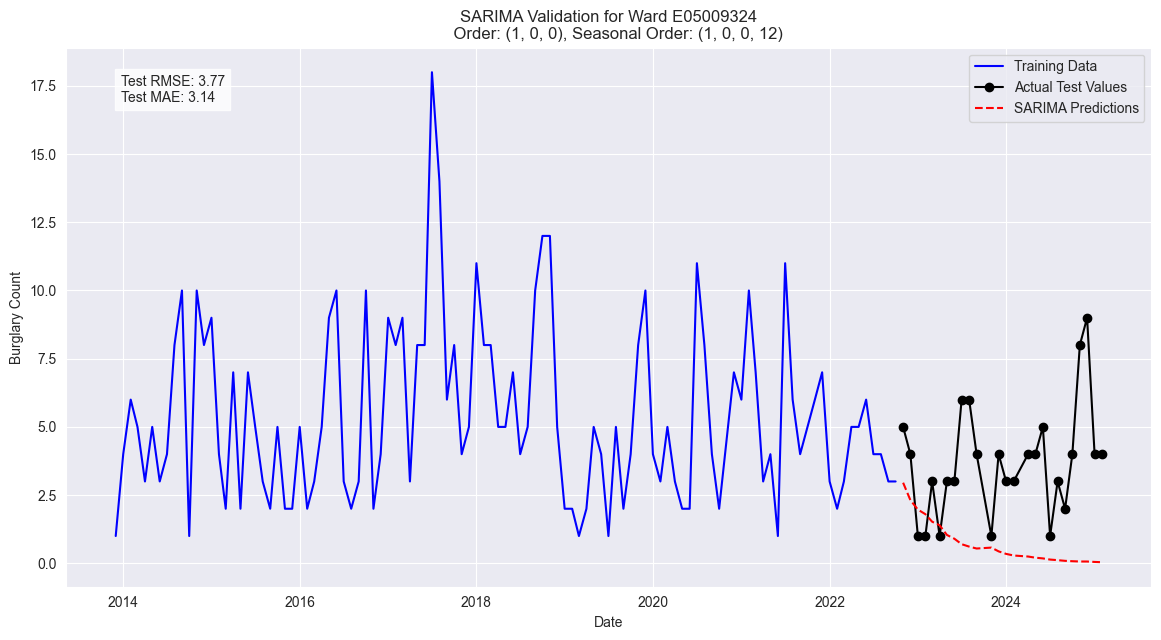


--------------------------------------------------
Residual Statistics for Ward E05009324:
Average Residual: 2.97
Residual Range: [-0.97, 8.93]
Positive Residuals: 88.5%


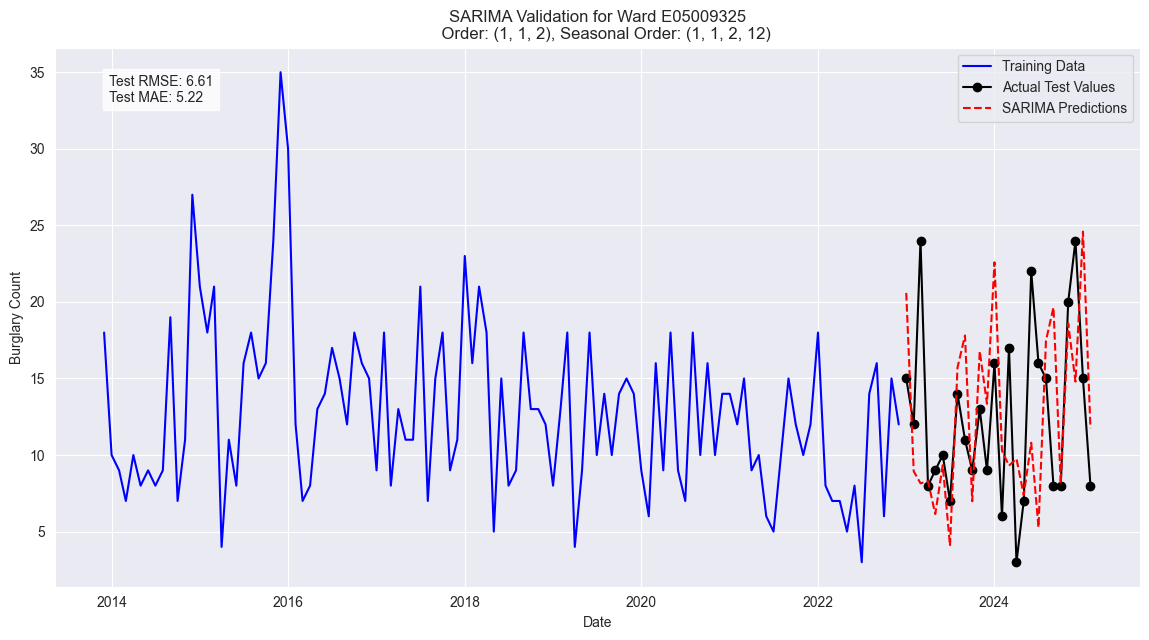


--------------------------------------------------
Residual Statistics for Ward E05009325:
Average Residual: -0.02
Residual Range: [-11.64, 15.85]
Positive Residuals: 42.3%


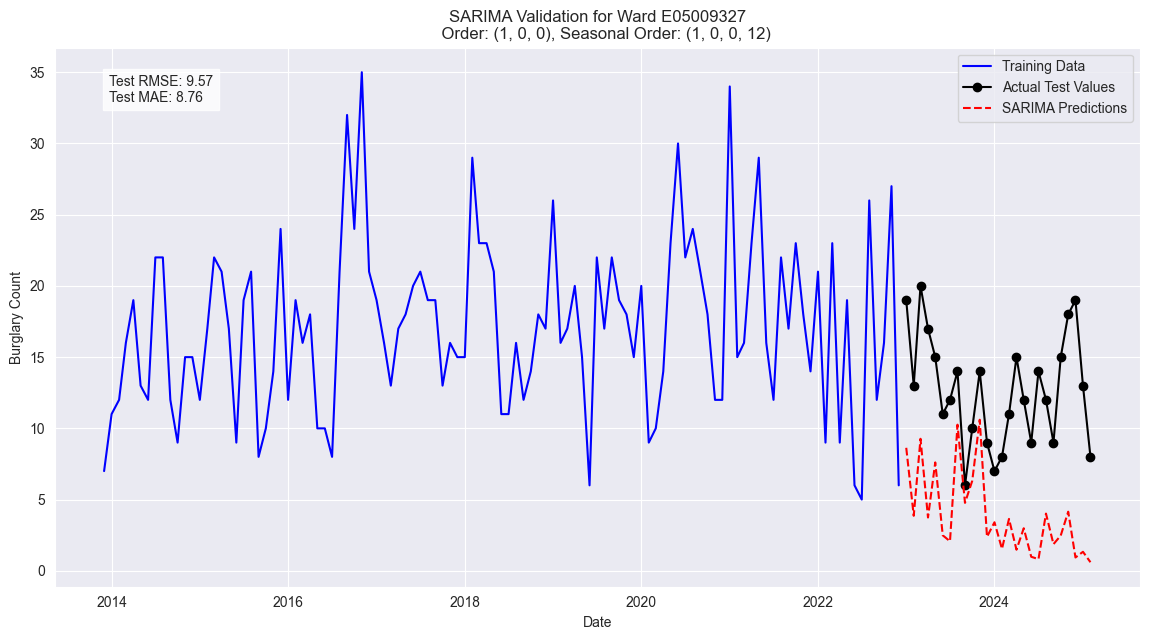


--------------------------------------------------
Residual Statistics for Ward E05009327:
Average Residual: 8.76
Residual Range: [1.23, 18.06]
Positive Residuals: 100.0%


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_sarima_validation(result):
    """Plot training data, actual test values and predictions for a single ward"""
    plt.figure(figsize=(14, 7))

    # Extract data
    ward_code = result['ward_code']
    train_dates = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Month'].iloc[:-26]
    train_counts = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Count'].iloc[:-26]
    test_dates = burglary_monthly[burglary_monthly['Ward Code'] == ward_code]['Month'].iloc[-26:]

    # Create plots
    plt.plot(train_dates, train_counts, 'b-', label='Training Data')
    plt.plot(test_dates, result['actual'], 'ko-', label='Actual Test Values')
    plt.plot(test_dates, result['predicted'], 'r--', label='SARIMA Predictions')

    # Formatting
    plt.title(f'''SARIMA Validation for Ward {ward_code}
    Order: {result['model_order']}, Seasonal Order: {result['model_seasonal_order']}''')
    plt.xlabel('Date')
    plt.ylabel('Burglary Count')
    plt.legend()
    plt.grid(True)

    # Add metrics
    rmse = np.sqrt(mean_squared_error(result['actual'], result['predicted']))
    mae = mean_absolute_error(result['actual'], result['predicted'])
    plt.text(0.05, 0.95,
            f'Test RMSE: {rmse:.2f}\nTest MAE: {mae:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

# Plot first 3 wards as examples
for i, result in enumerate(results[:10]):
    plot_sarima_validation(result)
    print(f"\n{'-'*50}\nResidual Statistics for Ward {result['ward_code']}:")
    print(f"Average Residual: {np.mean(result['residuals']):.2f}")
    print(f"Residual Range: [{np.min(result['residuals']):.2f}, {np.max(result['residuals']):.2f}]")
    print(f"Positive Residuals: {np.sum(result['residuals'] > 0)/len(result['residuals']):.1%}")
